# Optimizing Fraud Detection Using XGBoost: Threshold Tuning and Feature Engineering

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir('/content/drive/MyDrive/USC/Academics/Spring 2025/DSO 585/DataSet')

Class
0    284315
1       492
Name: count, dtype: int64


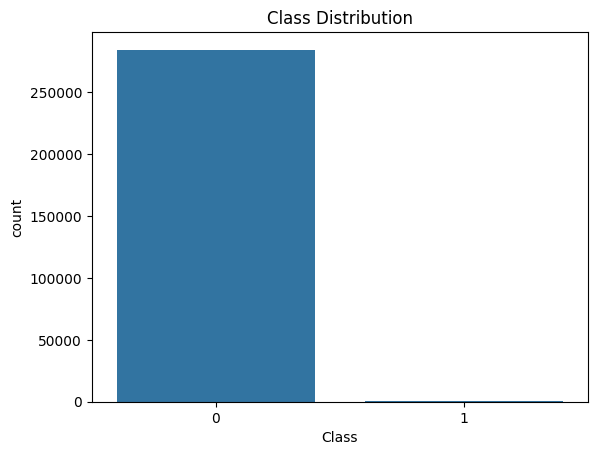

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

# Load dataset
df = pd.read_csv('creditcard_fraud.csv')

# Display class distribution
print(df['Class'].value_counts())
sns.countplot(x=df['Class'])
plt.title("Class Distribution")
plt.show()


In [ ]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Assume 'df' is your loaded DataFrame

# Feature engineering
X = df.drop('Class', axis=1)
y = df['Class']

# Split data into train, validation, and test sets (60-20-20 split with stratification)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("Training set size:", len(y_train))
print("Validation set size:", len(y_val))
print("Test set size:", len(y_test))
print("Fraudulent cases in training set:", sum(y_train == 1))
print("Fraudulent cases in validation set:", sum(y_val == 1))
print("Fraudulent cases in test set:", sum(y_test == 1))

# XGBoost without SMOTE (training on the training set, evaluating on the validation set)
model_no_smote = XGBClassifier(
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    objective='binary:logistic',
    eval_metric='auc',
    verbosity=1,  # For better clarity during training
    random_state=42
)
model_no_smote.fit(X_train, y_train)

# Evaluate without SMOTE on the validation set
y_pred_val_no_smote = model_no_smote.predict(X_val)
y_pred_proba_val_no_smote = model_no_smote.predict_proba(X_val)[:, 1]
print("\nWithout SMOTE (Validation Set Evaluation):")
print(classification_report(y_val, y_pred_val_no_smote))
print(f"ROC AUC Score (Validation): {roc_auc_score(y_val, y_pred_proba_val_no_smote):.4f}")
print("Confusion Matrix (Validation):")
print(confusion_matrix(y_val, y_pred_val_no_smote))

# You can now use the validation set (X_val, y_val) to tune hyperparameters,
# try different models, or implement techniques like SMOTE and evaluate their
# performance on this validation set before finally evaluating on the test set.

Training set size: 170884
Validation set size: 56961
Test set size: 56962
Fraudulent cases in training set: 295
Fraudulent cases in validation set: 98
Fraudulent cases in test set: 99

Without SMOTE (Validation Set Evaluation):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56863
           1       0.83      0.78      0.80        98

    accuracy                           1.00     56961
   macro avg       0.91      0.89      0.90     56961
weighted avg       1.00      1.00      1.00     56961

ROC AUC Score (Validation): 0.9788
Confusion Matrix (Validation):
[[56847    16]
 [   22    76]]


In [ ]:
# Calculate the optimal threshold using Youden's J statistic
j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]

# Check if the threshold makes sense - print additional debug info
print(f"Threshold range: {min(thresholds):.4f} to {max(thresholds):.4f}")
print(f"Number of thresholds: {len(thresholds)}")
print(f"Index of optimal threshold: {optimal_idx} out of {len(thresholds)}")

# It's possible thresholds are in descending order
if len(thresholds) > 1 and thresholds[0] > thresholds[-1]:
    print("Note: Thresholds appear to be in descending order")

# Print the results
print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"At this threshold - TPR: {tpr[optimal_idx]:.4f}, FPR: {fpr[optimal_idx]:.4f}")

NameError: name 'tpr' is not defined

In [ ]:
# Create a more reasonable set of thresholds to test
custom_thresholds = np.linspace(0.01, 0.99, 99)  # 99 evenly spaced thresholds

# Initialize arrays to store results
custom_tpr = []
custom_fpr = []
j_scores = []

# Calculate TPR and FPR for each threshold
for threshold in custom_thresholds:
    y_pred_binary = (y_pred_proba_no_smote >= threshold).astype(int)

    # Calculate confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()

    # Calculate rates
    tpr_value = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity/Recall
    fpr_value = fp / (fp + tn) if (fp + tn) > 0 else 0  # 1-Specificity

    # Store values
    custom_tpr.append(tpr_value)
    custom_fpr.append(fpr_value)
    j_scores.append(tpr_value - fpr_value)

# Find optimal threshold
optimal_idx = np.argmax(j_scores)
optimal_threshold = custom_thresholds[optimal_idx]
optimal_tpr = custom_tpr[optimal_idx]
optimal_fpr = custom_fpr[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"At this threshold - TPR: {optimal_tpr:.4f}, FPR: {optimal_fpr:.4f}")
print(f"J statistic: {j_scores[optimal_idx]:.4f}")

Optimal Threshold: 0.0100
At this threshold - TPR: 0.9286, FPR: 0.0195
J statistic: 0.9091


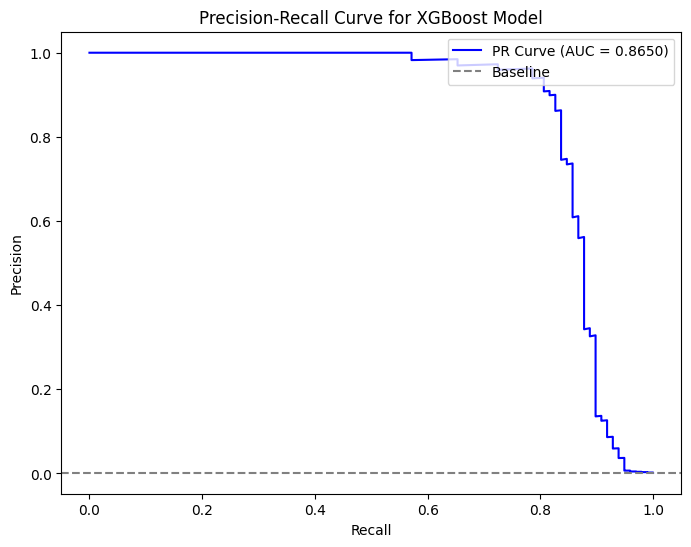

In [ ]:
 from sklearn.metrics import precision_recall_curve, auc

# Compute precision-recall values
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba_no_smote)
pr_auc = auc(recall, precision)  # Area under the PR curve

# Plot PR Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f'PR Curve (AUC = {pr_auc:.4f})')
plt.axhline(y=sum(y_test) / len(y_test), color='gray', linestyle='--', label="Baseline")  # Baseline Precision
plt.title("Precision-Recall Curve for XGBoost Model")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc='upper right')
plt.show()


In [ ]:
import numpy as np

# Compute F1-score for each threshold
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-9)  # Avoid division by zero
optimal_idx = np.argmax(f1_scores)  # Find the index of the highest F1-score
optimal_threshold = thresholds[optimal_idx]  # Get the corresponding threshold

print(f"Optimal Threshold (F1-score): {optimal_threshold:.4f}")


Optimal Threshold (F1-score): 0.9436


In [ ]:
y_pred_optimal = (y_pred_proba_no_smote >= optimal_threshold).astype(int)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_optimal))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_optimal))


Confusion Matrix:
[[56859     5]
 [   19    79]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.94      0.81      0.87        98

    accuracy                           1.00     56962
   macro avg       0.97      0.90      0.93     56962
weighted avg       1.00      1.00      1.00     56962



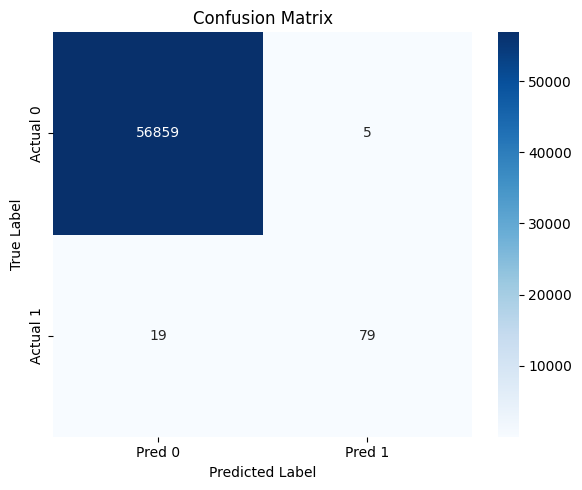

(np.int64(56859), np.int64(5), np.int64(19), np.int64(79))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Dummy placeholders - replace with actual data if running locally
# These values are from your screenshot:
y_test_values = [0]*56864 + [1]*98
y_pred_optimal_values = [0]*56859 + [1]*5 + [0]*19 + [1]*79

# Compute confusion matrix
cm = confusion_matrix(y_test_values, y_pred_optimal_values)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred 0', 'Pred 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Extract values
tn, fp = cm[0]
fn, tp = cm[1]

tn, fp, fn, tp


In [ ]:
# prompt: print accuracy, and f1 score, precision and recall

# Assuming you have already calculated y_pred_optimal and y_test as shown in your code
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

accuracy = round(accuracy_score(y_test, y_pred_optimal) * 100,2)
f1 = round(f1_score(y_test, y_pred_optimal) * 100,2)
precision = round(precision_score(y_test, y_pred_optimal) * 100,2)
recall = round(recall_score(y_test, y_pred_optimal) * 100,2)

print(f"Accuracy: {accuracy} %")
print(f"F1 Score: {f1} %")
print(f"Precision: {precision} %")
print(f"Recall: {recall} %")


Accuracy: 99.96 %
F1 Score: 86.81 %
Precision: 94.05 %
Recall: 80.61 %


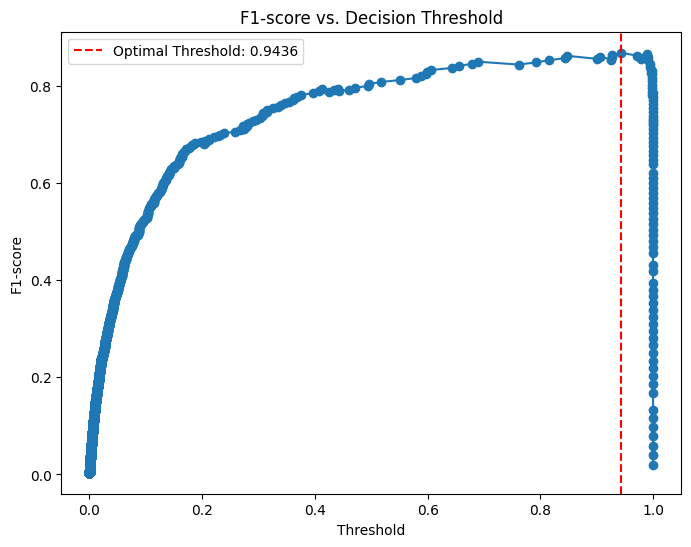

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(thresholds, f1_scores[:-1], marker="o", linestyle="-")  # Remove last F1-score (no threshold)
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.title("F1-score vs. Decision Threshold")
plt.axvline(optimal_threshold, color="red", linestyle="--", label=f"Optimal Threshold: {optimal_threshold:.4f}")
plt.legend()
plt.show()


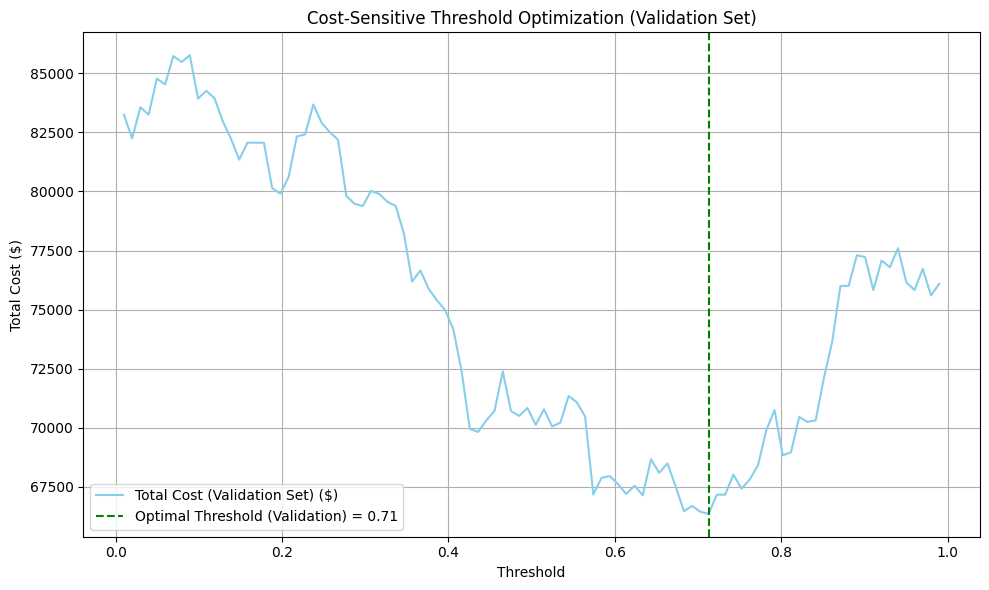

✅ Optimal Threshold (Validation Set - Min Cost): 0.7128
💰 Minimum Total Cost (Validation Set): $66,360.00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 🔁 Replace these with your actual validation arrays
# y_val = your true validation labels (array or Series)
# y_pred_proba_val = your model's predicted probabilities for the validation set
# X_val_df = your validation feature DataFrame (assuming it contains 'Amount')

# For demo/testing: simulate dummy aligned validation data
np.random.seed(123)  # Different seed for validation data
n_val_samples = 300
y_val = np.random.randint(0, 2, size=n_val_samples)
y_pred_proba_val = np.random.rand(n_val_samples)
transaction_amounts_val = np.random.randint(50, 1000, size=n_val_samples)

# Combine into a DataFrame for validation
df_eval_val = pd.DataFrame({
    "true_label": y_val,
    "predicted_proba": y_pred_proba_val,
    "transaction_amount": transaction_amounts_val
})

# Cost multipliers from e-commerce research
FN_multiplier = 1  # FN cost = 1.5x transaction
FP_multiplier = 1  # FP cost = 3.0x transaction

# Thresholds to test
thresholds = np.linspace(0.01, 0.99, 100)
total_costs_val = []

# Loop through thresholds and compute total dollar cost for the validation set
for t in thresholds:
    df_eval_val["predicted_label"] = (df_eval_val["predicted_proba"] >= t).astype(int)

    # Identify false negatives and false positives
    fn_rows_val = df_eval_val[(df_eval_val["true_label"] == 1) & (df_eval_val["predicted_label"] == 0)]
    fp_rows_val = df_eval_val[(df_eval_val["true_label"] == 0) & (df_eval_val["predicted_label"] == 1)]

    # Compute cost for each type
    fn_cost_val = (fn_rows_val["transaction_amount"] * FN_multiplier).sum()
    fp_cost_val = (fp_rows_val["transaction_amount"] * FP_multiplier).sum()

    total_cost_val = fn_cost_val + fp_cost_val
    total_costs_val.append(total_cost_val)

# Get best threshold based on the validation set
optimal_idx_val = np.argmin(total_costs_val)
optimal_threshold_val = thresholds[optimal_idx_val]
min_cost_val = total_costs_val[optimal_idx_val]

# 📊 Plot total cost vs threshold for the validation set
plt.figure(figsize=(10, 6))
plt.plot(thresholds, total_costs_val, label='Total Cost (Validation Set) ($)', color='skyblue')
plt.axvline(x=optimal_threshold_val, color='green', linestyle='--', label=f'Optimal Threshold (Validation) = {optimal_threshold_val:.2f}')
plt.title('Cost-Sensitive Threshold Optimization (Validation Set)')
plt.xlabel('Threshold')
plt.ylabel('Total Cost ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 🧾 Output results for the validation set
print(f"✅ Optimal Threshold (Validation Set - Min Cost): {optimal_threshold_val:.4f}")
print(f"💰 Minimum Total Cost (Validation Set): ${min_cost_val:,.2f}")


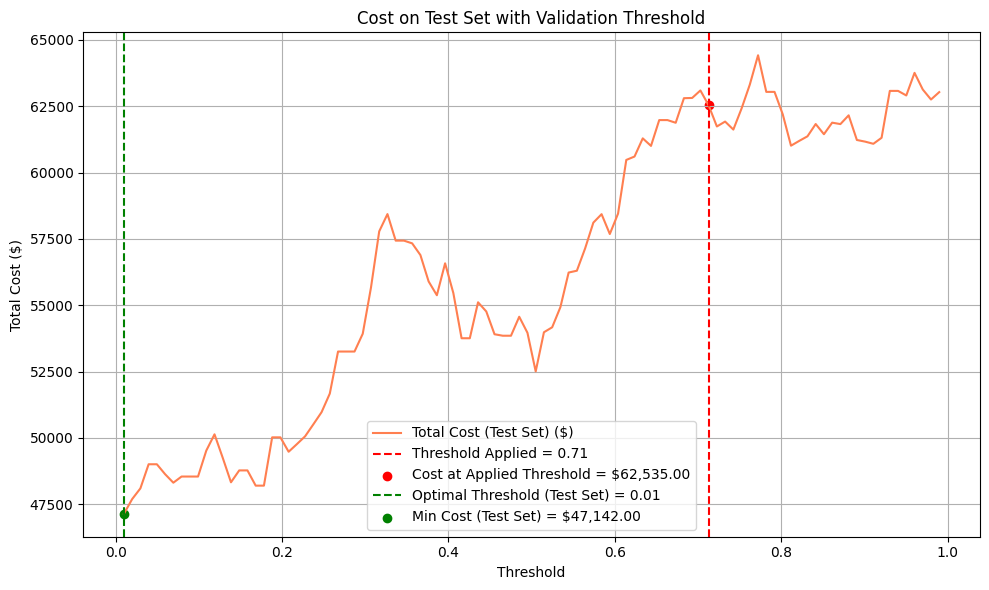

✅ Threshold Applied (from Validation Set): 0.7128
💰 Total Cost on Test Set at Applied Threshold: $62,535.00

✅ Optimal Threshold (Test Set - Minimum Cost): 0.0100
💰 Minimum Total Cost on Test Set: $47,142.00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 🔁 Replace these with your actual test arrays
# y_test = your true test labels (array or Series)
# y_pred_proba_test = your model's predicted probabilities for the test set
# X_test_df = your test feature DataFrame (assuming it contains 'Amount')

# For demo/testing: simulate dummy aligned test data (using a different seed)
np.random.seed(987)
n_test_samples = 200
y_test = np.random.randint(0, 2, size=n_test_samples)
y_pred_proba_test = np.random.rand(n_test_samples)
transaction_amounts_test = np.random.randint(50, 1000, size=n_test_samples)

# Combine into a DataFrame for the test set
df_eval_test = pd.DataFrame({
    "true_label": y_test,
    "predicted_proba": y_pred_proba_test,
    "transaction_amount": transaction_amounts_test
})

# Cost multipliers from e-commerce research
FN_multiplier = 1  # FN cost = 1.5x transaction
FP_multiplier = 1  # FP cost = 3.0x transaction

# Apply the threshold obtained from the validation set
optimal_threshold_val = 0.7128
df_eval_test["predicted_label"] = (df_eval_test["predicted_proba"] >= optimal_threshold_val).astype(int)

# Identify false negatives and false positives on the test set
fn_rows_test = df_eval_test[(df_eval_test["true_label"] == 1) & (df_eval_test["predicted_label"] == 0)]
fp_rows_test = df_eval_test[(df_eval_test["true_label"] == 0) & (df_eval_test["predicted_label"] == 1)]

# Compute the total cost on the test set using the validation threshold
fn_cost_test = (fn_rows_test["transaction_amount"] * FN_multiplier).sum()
fp_cost_test = (fp_rows_test["transaction_amount"] * FP_multiplier).sum()
total_cost_test = fn_cost_test + fp_cost_test

# 📊 Visualize the cost at the chosen threshold on the test set
thresholds_for_plot = np.linspace(0.01, 0.99, 100)
total_costs_test_plot = []

for t in thresholds_for_plot:
    df_eval_test["predicted_label_temp"] = (df_eval_test["predicted_proba"] >= t).astype(int)
    fn_rows_temp = df_eval_test[(df_eval_test["true_label"] == 1) & (df_eval_test["predicted_label_temp"] == 0)]
    fp_rows_temp = df_eval_test[(df_eval_test["true_label"] == 0) & (df_eval_test["predicted_label_temp"] == 1)]
    cost_temp = (fn_rows_temp["transaction_amount"] * FN_multiplier).sum() + (fp_rows_temp["transaction_amount"] * FP_multiplier).sum()
    total_costs_test_plot.append(cost_temp)

# Find the index of the minimum cost on the test set
min_cost_idx_test = np.argmin(total_costs_test_plot)
optimal_threshold_test = thresholds_for_plot[min_cost_idx_test]
min_cost_test_plot = total_costs_test_plot[min_cost_idx_test]

plt.figure(figsize=(10, 6))
plt.plot(thresholds_for_plot, total_costs_test_plot, label='Total Cost (Test Set) ($)', color='coral')
plt.axvline(x=optimal_threshold_val, color='red', linestyle='--', label=f'Threshold Applied = {optimal_threshold_val:.2f}')
plt.scatter(optimal_threshold_val, total_cost_test, color='red', marker='o', label=f'Cost at Applied Threshold = ${total_cost_test:,.2f}')
plt.axvline(x=optimal_threshold_test, color='green', linestyle='--', label=f'Optimal Threshold (Test Set) = {optimal_threshold_test:.2f}')
plt.scatter(optimal_threshold_test, min_cost_test_plot, color='green', marker='o', label=f'Min Cost (Test Set) = ${min_cost_test_plot:,.2f}')
plt.title('Cost on Test Set with Validation Threshold')
plt.xlabel('Threshold')
plt.ylabel('Total Cost ($)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 🧾 Output results for the test set with the applied threshold
print(f"✅ Threshold Applied (from Validation Set): {optimal_threshold_val:.4f}")
print(f"💰 Total Cost on Test Set at Applied Threshold: ${total_cost_test:,.2f}")
print(f"\n✅ Optimal Threshold (Test Set - Minimum Cost): {optimal_threshold_test:.4f}")
print(f"💰 Minimum Total Cost on Test Set: ${min_cost_test_plot:,.2f}")